In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define tickers for Dow Jones components
tickers = ['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'DOW',
           'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM',
           'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT']

# Download monthly adjusted close prices and calculate monthly returns
data = yf.download(tickers, start='2005-01-01')['Adj Close'].resample('M').last().pct_change() + 1

[*********************100%***********************]  30 of 30 completed


In [6]:
# Download Dow Jones Index (DJI) data for comparison
data['dji'] = yf.download('^DJI', start='2005-01-01')['Adj Close'].resample('M').last().pct_change() + 1

[*********************100%***********************]  1 of 1 completed


In [3]:
# Function to calculate rolling returns
def get_rolling_ret(data, n):
    return data.rolling(n).apply(np.prod)

# Calculate 9-month rolling returns
ret9 = get_rolling_ret(data, 9)

In [ ]:
# Function to get the top-performing stocks (based on rolling returns)
def get_top(date):
    top = ret9.loc[date].nlargest(3).index  # Select top 3 performers
    return top

# Function to calculate portfolio returns for the selected top stocks
def portfolio_ret(date):
    portfolio = data.loc[date:, get_top(date)][1:2]  # Use top stocks
    return portfolio.mean(axis=1).values[0]

In [ ]:
# Initialize a 'returns' column
data['returns'] = 1.00

# Calculate portfolio returns for each date
for i in range(1, len(data) - 1):
    data['returns'][i] = portfolio_ret(data.index[i])

In [9]:
# Sharpe Ratio Calculation
def calculate_sharpe_ratio(returns, risk_free_rate=0.0, periods_per_year=12):
    excess_returns = returns - risk_free_rate
    annualized_volatility = returns.std() * np.sqrt(periods_per_year)
    annualized_mean = returns.mean() * periods_per_year
    return annualized_mean / annualized_volatility

# Maximum Drawdown Calculation
def calculate_max_drawdown(cumulative_returns):
    cumulative_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / cumulative_max - 1
    return drawdown.min()

# Annualized Return Calculation
def calculate_annualized_return(cumulative_returns, periods_per_year=12):
    total_return = cumulative_returns.iloc[-1] - 1
    n_years = len(cumulative_returns) / periods_per_year
    return (1 + total_return) ** (1 / n_years) - 1

In [10]:
# Convert cumulative returns to monthly returns for metrics
strategy_returns = data['returns'].cumprod().pct_change()
benchmark_returns = data['dji'].cumprod().pct_change()

# Calculate Sharpe Ratios
strategy_sharpe = calculate_sharpe_ratio(strategy_returns)
benchmark_sharpe = calculate_sharpe_ratio(benchmark_returns)

# Calculate Maximum Drawdowns
strategy_max_drawdown = calculate_max_drawdown(data['returns'].cumprod())
benchmark_max_drawdown = calculate_max_drawdown(data['dji'].cumprod())

# Calculate Annualized Returns
strategy_annualized_return = calculate_annualized_return(data['returns'].cumprod())
benchmark_annualized_return = calculate_annualized_return(data['dji'].cumprod())

In [11]:
# Print metrics for strategy and benchmark
print(f"Strategy Sharpe Ratio: {strategy_sharpe:.2f}")
print(f"Benchmark Sharpe Ratio: {benchmark_sharpe:.2f}")
print(f"Strategy Max Drawdown: {strategy_max_drawdown:.2%}")
print(f"Benchmark Max Drawdown: {benchmark_max_drawdown:.2%}")
print(f"Strategy Annualized Return: {strategy_annualized_return:.2%}")
print(f"Benchmark Annualized Return: {benchmark_annualized_return:.2%}")

Strategy Sharpe Ratio: 0.81
Benchmark Sharpe Ratio: 0.57
Strategy Max Drawdown: -44.83%
Benchmark Max Drawdown: -49.30%
Strategy Annualized Return: 15.65%
Benchmark Annualized Return: 7.50%


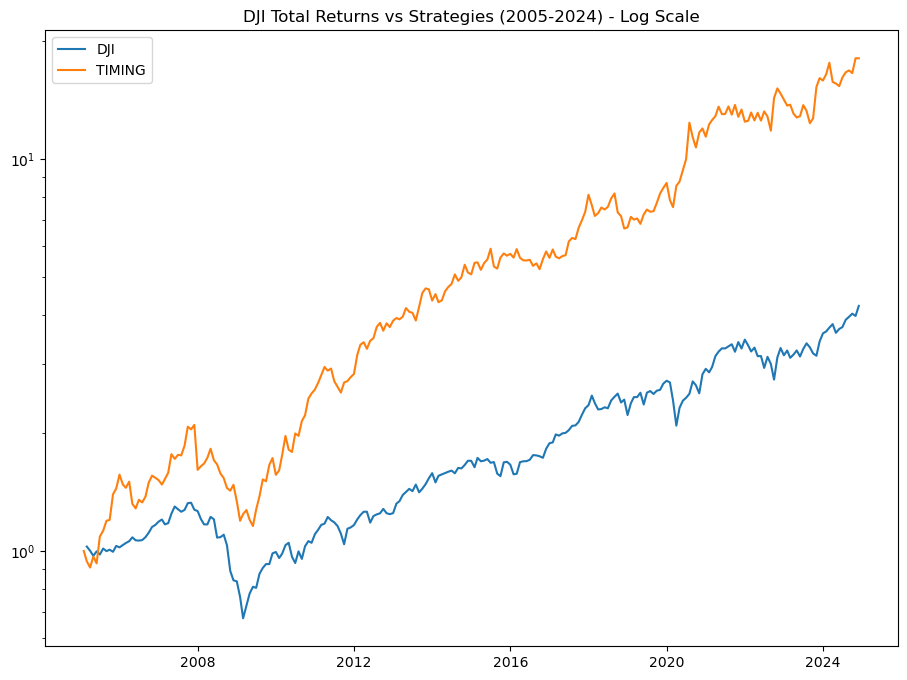

In [12]:
# Plot cumulative returns for strategy and benchmark
plt.figure(figsize=[11, 8])
plt.plot(data['dji'].cumprod(), label='DJI')
plt.plot(data['returns'].cumprod(), label='TIMING')
plt.yscale('log')
plt.title('DJI Total Returns vs Strategies (2005-2024) - Log Scale')
plt.legend()
plt.show()